In [171]:
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import datetime as dt
import math
from datetime import date

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# vars for easy manipulation
ticker = "VTSAX"
epo = 11 # epochs
hiddenLayerValue = 60
dropoutValue = 0.2
startDate = dt.datetime(2000, 1, 1)
todaysDate = date.today()
endDate = dt.datetime(2022, 4, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
trainDays = 100 # how many previous data points to look at
daysToPredict = 14
trainPercentage = .70 # how much of data set to use as training data

def preprocessData(xData, yData, trainDays, dataSet, size):
    # Preprocesses the data set into x and y arrays
    for x in range(trainDays, size): # load values
        xData.append(dataSet[x - trainDays:x, 0])
        yData.append((dataSet[x, 0]))

    # turn into numpy arrays and reshape to fit into LSTM
    xData, yData = np.array(xData), np.array(yData)
    xData = np.reshape(xData, (xData.shape[0], xData.shape[1], 1)) # reshape required for LSTM
    return xData, yData

# Collect Stock Data
data = pdr.DataReader(ticker, "yahoo", startDate, todaysDate)
closeValues = data['Close'].values    # closing value set to refer back to later
dataSet = data.reset_index()['Close'] # what we'll work with
dataSet = scaler.fit_transform(closeValues.reshape(-1,1))

# Preprocess data which is the training data set and the testing dataset
xTrain, yTrain = [], []
xTest, yTest = [], []
dataSetLength = len(dataSet)
trainSize = int(dataSetLength * trainPercentage)
testSize = (dataSetLength - trainSize)

# preprocess data into Training and Testing data
xTrain, yTrain = preprocessData(xTrain, yTrain, trainDays, dataSet[:trainSize,:], trainSize)
xTest, yTest = preprocessData(xTest, yTest, trainDays, dataSet[trainSize:len(dataSet), :1], testSize)

trainData, testData = dataSet[0:trainSize, :], dataSet[trainSize:len(dataSet), :1] # ceates numpy arrays by using the training and testing sizes

# Sequential model that uses LSTM
# Dropout layers may be unnecessary for this data
model = Sequential()
model.add(LSTM(hiddenLayerValue, return_sequences=True, input_shape=(100, 1)))
model.add(Dropout(dropoutValue)) # way to reduce overfitting of a small data set by randomly droping some layer outputs
model.add(LSTM(hiddenLayerValue, return_sequences=True))
model.add(Dropout(dropoutValue))
model.add(LSTM(hiddenLayerValue))
model.add(Dropout(dropoutValue))
model.add(Dense(1)) # one final output
model.compile(loss='mean_squared_error', optimizer='adam') # compile just means specifying optimizer and loss function used before you can fit it to data

model.fit(xTrain, yTrain, validation_data=(xTest, yTest), epochs=epo, batch_size=64, verbose=1)


Epoch 1/11
58/58 [==============================] - 24s 279ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 2/11
58/58 [==============================] - 13s 224ms/step - loss: 3.1836e-04 - val_loss: 0.0014
Epoch 3/11
58/58 [==============================] - 13s 227ms/step - loss: 2.7440e-04 - val_loss: 0.0014
Epoch 4/11
58/58 [==============================] - 13s 223ms/step - loss: 2.7137e-04 - val_loss: 0.0014
Epoch 5/11
58/58 [==============================] - 13s 224ms/step - loss: 2.4256e-04 - val_loss: 0.0012
Epoch 6/11
58/58 [==============================] - 14s 244ms/step - loss: 2.4384e-04 - val_loss: 0.0012
Epoch 7/11
58/58 [==============================] - 13s 228ms/step - loss: 2.2948e-04 - val_loss: 6.3806e-04
Epoch 8/11
58/58 [==============================] - 13s 223ms/step - loss: 2.2455e-04 - val_loss: 5.2746e-04
Epoch 9/11
58/58 [==============================] - 13s 229ms/step - loss: 2.0792e-04 - val_loss: 7.1421e-04
Epoch 10/11
58/58 [============================

33.31190787810121
76.27958891910595


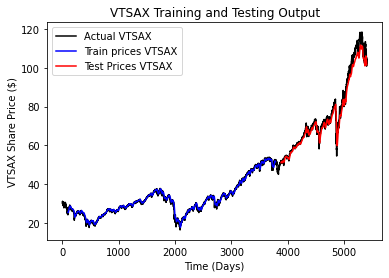

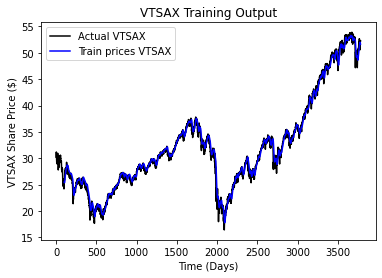

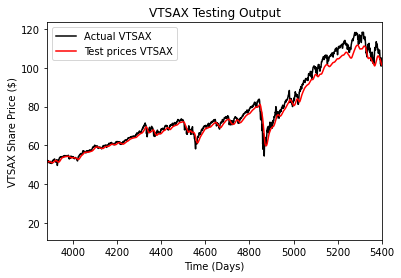

In [172]:
# Predict test data and plot
# Create arrays of predicted data and shove them into a graph
# Make graph understandable
trainPrediction = model.predict(xTrain)
testPrediction = model.predict(xTest)

trainPrediction = scaler.inverse_transform(trainPrediction)    # reverses the scaling we did to get data between 1 and 0
testPrediction = scaler.inverse_transform(testPrediction)

print(math.sqrt(mean_squared_error(yTrain, trainPrediction)))   # performance matrix
print(math.sqrt(mean_squared_error(yTest, testPrediction)))   # performance matrix

trainPredictPlot = np.empty_like(dataSet)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[trainDays:len(trainPrediction)+trainDays, :] = trainPrediction # basically just places them correctly on the graph

testPredictPlot = np.empty_like(dataSet)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPrediction)+(trainDays * 2)-1:len(dataSet)-1, :] = testPrediction

# Plot the test predictions
plt.plot(closeValues, color="black", label=f"Actual {ticker}")
plt.plot(trainPredictPlot, color="blue", label=f"Train prices {ticker}")
plt.plot(testPredictPlot, color="red", label=f"Test Prices {ticker}")
plt.title(f"{ticker} Training and Testing Output")
plt.xlabel("Time (Days)")
plt.ylabel(f"{ticker} Share Price ($)")
plt.legend()
plt.show()

# plot just training data
plt.plot(closeValues[:len(trainPrediction)+ (trainDays)], color="black", label=f"Actual {ticker}")
plt.plot(trainPredictPlot, color="blue", label=f"Train prices {ticker}")
plt.title(f"{ticker} Training Output")
plt.xlabel("Time (Days)")
plt.ylabel(f"{ticker} Share Price ($)")
plt.legend()
plt.show()

# plot just test data
fig, main_ax = plt.subplots()
plt.plot(closeValues, color="black", label=f"Actual {ticker}")
plt.plot(testPredictPlot, color="red", label=f"Test prices {ticker}")
main_ax.set_xlim(len(trainPrediction)+(trainDays*2), len(closeValues))
plt.title(f"{ticker} Testing Output")
plt.xlabel("Time (Days)")
plt.ylabel(f"{ticker} Share Price ($)")
plt.legend()
plt.show()

In [173]:
# Predict the future days and plot
xInput = testData[(len(testData))-trainDays:].reshape(1, -1)
tempInput=list(xInput)    # convert to a list
tempInput=tempInput[0].tolist()

finalOutput=[]
for i in range(daysToPredict):
    if(len(tempInput)>trainDays):
        xInput=np.array(tempInput[1:]) # shift one position to the right
        xInput=xInput.reshape(1,-1)   # always reshape before using LSTM
        xInput = xInput.reshape((1, trainDays, 1))
        yOut = model.predict(xInput, verbose=0)
        tempInput.extend(yOut[0].tolist())
        tempInput=tempInput[1:]
        finalOutput.extend(yOut.tolist())

    else:   # starts here first since tempInput length should be 100
        xInput = xInput.reshape((1, trainDays,1)) # reshape to fit into the LSTM model
        yOut = model.predict(xInput, verbose=0)
        tempInput.extend(yOut[0].tolist()) # add to temp
        finalOutput.extend(yOut.tolist()) # add yOut value to final output (one day)

    


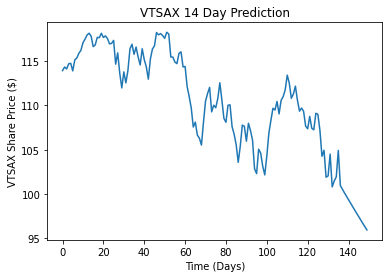

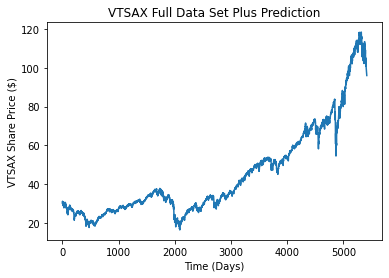

In [174]:
# combine the original data set with new prediction
dataSetPredicted=dataSet.tolist()
dataSetPredicted.extend(finalOutput)
showPredicted = dataSetPredicted[len(dataSetPredicted)-150:]

# 14 day prediction graph
plt.plot(scaler.inverse_transform(showPredicted))
plt.title(f"{ticker} {daysToPredict} Day Prediction")
plt.xlabel("Time (Days)")
plt.ylabel(f"{ticker} Share Price ($)")
plt.show()

# Full prediction graph
dataSetPredicted=scaler.inverse_transform(dataSetPredicted).tolist()
plt.plot(dataSetPredicted)
plt.title(f"{ticker} Full Data Set Plus Prediction")
plt.xlabel("Time (Days)")
plt.ylabel(f"{ticker} Share Price ($)")
plt.show()